# SEAIRQ model with realistic testing rates

In this notebook, we consider the effect of testing and quarantining parts of the population. We use a variant of 
the SEAIRQ model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, and quarantined. Importantly, the rates for the transition to the quarantined class are not fixed, but dependent on time and the state of the epidemic. They follow a simple model for random and symptomatic tests that is informed by the daily number of tests performed. Admissible for testing is a fraction $\alpha_{rs}$ of the total population considered for testing, either at random or based on symptoms similar to covid19, as well as the class $I^s$ of actual symptomatic infectives. 

We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\alpha_{rs}$ (fraction of the population admissible for random and symptomatic testing)

as well as the true state of the epidemic
from partially observed data ($Q$ only) from a generated trajectory. Here, $Q$ can be regarded as the number of confirmed cases (which are properly quarantined), which is in a realistic scenario the only observable stage. For simplicity, we do not consider any mitigation strategies other than testing and quarantining.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two age groups.

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3
          
ars    = 0.01      # fraction of population admissible for testing 
kapE    = 0.5      # fraction of exposed population tested positive    




# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([100, 100])
A0  = np.array([10, 10])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C


parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'ars':ars,'kapE':kapE, 
             'gAA': gA, 'gAS': gA} # legacy code 



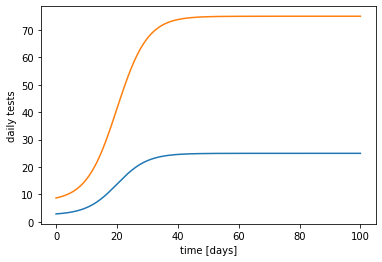

In [4]:
# Set the test rate as a function of time, proportional to the size of the age group

def testRate(t):
    return (90.*(1.+np.tanh((t-20.)/10.))/2.+10.)*fi

# plot the test rate
tt = np.linspace(0,Tf,1024)
TR = [testRate(t) for t in tt]
plt.plot(tt,TR)
plt.xlabel("time [days]")
plt.ylabel("daily tests")
plt.show()

In [5]:
# use pyross deterministic to generate traj 
det_model = pyross.deterministic.SEAIRQ_testing(parameters, M, Ni)
data = det_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, testRate, Tf, Nf)
data_array = data['X']

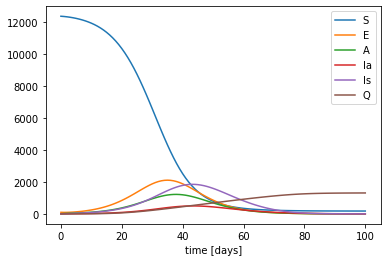

In [6]:
# plot the deterministic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
#plt.plot(data_array[:, 4*M+1], label='Is2')
plt.plot(data_array[:, 5*M], label='Q')
#plt.plot(data_array[:, 5*M+1], label='Q2')
plt.legend()
plt.xlabel("time [days]")
plt.show()

In [7]:
# use pyross stochastic to generate traj 
sto_model = pyross.stochastic.SEAIRQ_testing(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, testRate, Tf, Nf)
data_array_sto = data['X']

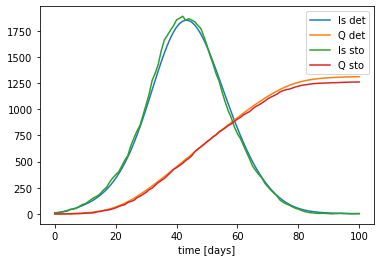

In [8]:
# plot the deterministic and stochastic solutions
plt.plot(data_array[:, 4*M], label='Is det')
plt.plot(data_array[:, 5*M], label='Q det')
plt.plot(data_array_sto[:, 4*M], label='Is sto')
plt.plot(data_array_sto[:, 5*M], label='Q sto')
plt.legend()
plt.xlabel("time [days]")
plt.show()

## 2) Inference

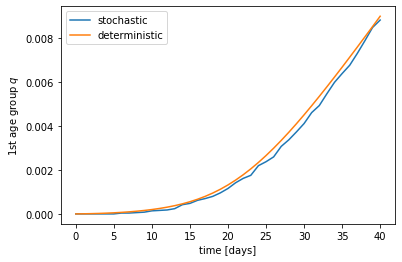

In [9]:
Tf_inference = 40 
Nf_inference = Tf_inference + 1
x=data_array_sto[:Nf_inference]/N
steps = 101
# initialise the estimator 
estimator = pyross.inference.SEAIRQ_testing(parameters, testRate, M, fi, int(N), steps)

# only sum over all age groups in Q visible
fltr=np.array([np.repeat(np.array([0, 0, 0, 0, 0, 1]), M)])
obs=np.array([np.sum(x[:, (5*M):],1)]).transpose()

# all age groups in Q visible
#fltr=np.kron(([0, 0, 0, 0, 0, 1]), np.identity(M))
#obs=x[:,(5*M):(6*M)]

x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
xm = estimator.integrate(x[0,:], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
plt.plot(x[:,5*M],label="stochastic")
plt.plot(xm[:,5*M],label="deterministic")
plt.xlabel("time [days]")
plt.ylabel("1st age group $q$")
plt.legend()
plt.show()

In [10]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time() 
print(logp)
print(end_time - start_time)

-314.24197371107596
0.5138347148895264


In [11]:
# compute -log_p for the incorrect parameters 
parameters_wrong=parameters.copy()
parameters_wrong['beta']=0.03
logp = estimator.minus_logp_red(parameters_wrong, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(logp)

-283.040223954002


In [12]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

alpha_g = 0.22
alpha_std = 0.05 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.015
beta_std = 0.005
beta_bounds = (eps, 1)

ars_g = 0.02
ars_std = 0.02
ars_bounds = (eps,0.1)

# not inferred

gIa_g   = 1./7           
gIs_g   = 1/7
fsa_g   = 0.8          
gE_g    = 1/5
gA_g    = 1/3
kapE_g  = 0.5    


# Guesses and bounds for initial conditions

E0_g = (E0+3)/N
E_std = E0_g*0.2
bounds_for_E = np.tile([0.1/N, 1000/N], M).reshape(M, 2)

A0_g = (A0+3)/N
A_std = A0_g*0.2 
bounds_for_A = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.2 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = (Is0+3)/N
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['alpha', 'beta', 'ars']
bounds = np.array([alpha_bounds, beta_bounds, ars_bounds,
                   *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, ars_g, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, ars_std, *S_std, *E_std, *A_std, *Ia_std, *Is_std])

# set up filter for initial conditions because they are constraint by the observed 
# note that this filter is different from the bulk of the trajectory, 
# because we know the initial value Q=0 holds for all age groups
init_fltr = np.repeat([True, True, True, True, True, False], M)
fltr0=np.kron(([0, 0, 0, 0, 0, 1]), np.identity(M))
obs0=np.zeros(M)



start_time = time.time()
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=10, global_atol=10, 
                                    verbose=True, ftol=ftol,obs0=obs0,fltr0=fltr0) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 13 (seed=3174753780, Thu Jun  4 15:07:05 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.006266681850785e+14 1.0e+00 9.40e-01  5e-05  5e-02 0:05.5
    2     32 -2.550513615412794e+02 1.1e+00 9.77e-01  5e-05  5e-02 0:10.1
    3     48 -3.977574417482321e+02 1.3e+00 1.05e+00  5e-05  5e-02 0:15.7
    4     64 -3.790206898917201e+02 1.4e+00 1.13e+00  6e-05  6e-02 0:20.9
    5     80 -4.027910355695004e+02 1.4e+00 1.16e+00  6e-05  6e-02 0:25.0
    7    112 -4.022841640492717e+02 1.6e+00 1.13e+00  6e-05  6e-02 0:33.9
    9    144 -4.035254441781735e+02 1.6e+00 1.03e+00  5e-05  5e-02 0:42.9
Optimal value (global minimisation):  -403.52544417817353
Starting local minimisation...
Optimal value (local minimisation):  -403.528068871384
64.48583674430847


In [13]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Q0)

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs0, init_fltr, fltr0)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gE': 0.2, 'gA': 0.3333333333333333, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8, 'ars': 0.01, 'kapE': 0.5, 'gAA': 0.3333333333333333, 'gAS': 0.3333333333333333}

 Best estimates
{'alpha': 0.21746755046804467, 'beta': 0.02004357469058588, 'gIa': array([0.14285714, 0.14285714]), 'gIs': array([0.14285714, 0.14285714]), 'gE': array([0.2, 0.2]), 'gA': array([0.33333333, 0.33333333]), 'fsa': array([0.8, 0.8]), 'ars': 0.009433161005754344, 'kapE': array([0.5, 0.5])}

 True initial conditions: 
[12370. 37370.] [100 100] [10 10] [10 10] [10 10] [0 0]

 Inferred initial conditons: 
[12366 37357    83    81    13    12    13    12     9    13     0     0]


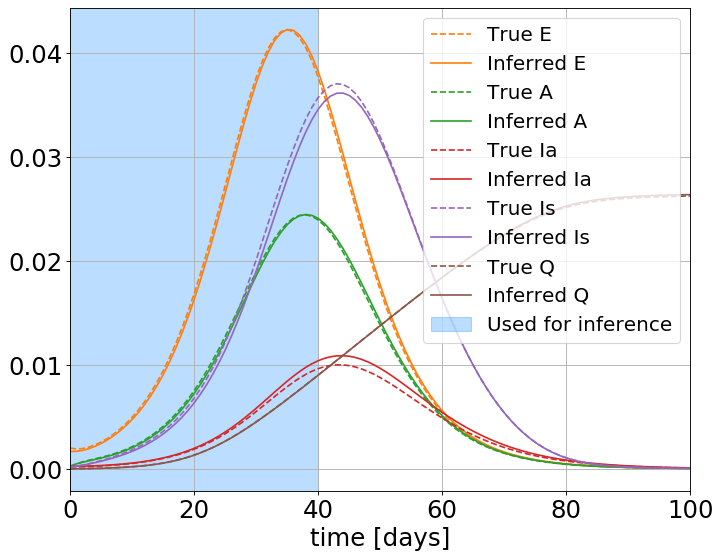

In [14]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = pyross.deterministic.SEAIRQ_testing(best_estimates, M, Ni)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x=data_array/N
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,1*M], label='True E', ls='--', c='C1')
plt.plot(x_det[:, 1*M], label='Inferred E', c='C1')
plt.plot(x[:,2*M], label='True A', ls='--', c='C2')
plt.plot(x_det[:, 2*M], label='Inferred A', c='C2')
plt.plot(x[:,3*M], label='True Ia', ls='--', c='C3')
plt.plot(x_det[:, 3*M], label='Inferred Ia', c='C3')
plt.plot(x[:,4*M], label='True Is', ls='--', c='C4')
plt.plot(x_det[:, 4*M], label='Inferred Is', c='C4')
plt.plot(x[:,5*M], label='True Q', ls='--', c='C5')
plt.plot(x_det[:, 5*M], label='Inferred Q', c='C5')

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## Conclusion
The quarantining based on (low scale) random and symptomatic testing does not allow for an effective reduction of the number of infectives. In this toy model, the disease is spread largely by asymptomatic infectives, which are rarely quarantined. Nonetheless, modeling the testing process allows one to estimate the full extent of the epidemic from an incomplete number of tested individuals. 